<a href="https://colab.research.google.com/github/TomasPastore/aprendizaje_automatico_tp/blob/main/tp_AA_grupo_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import timeit

# Lectura del dataset

In [ ]:
url = 'https://raw.githubusercontent.com/aprendizaje-automatico-dc-uba-ar/material/main/tp/01_aprendizaje_supervisado/datos/minions_publicos.csv'
minions_dataset = pd.read_csv(url)

y = minions_dataset.iloc[:,-1:]
print(y[y["target"] == 1])

del minions_dataset[minions_dataset.columns[-1]]
print("\n Features")
minions_dataset

     target
0         1
1         1
2         1
3         1
5         1
..      ...
483       1
490       1
491       1
497       1
499       1

[154 rows x 1 columns]

 Features


,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199
0,0.203777,-7.278026,2.756077,0.412740,-0.116626,0.414236,6.218588,0.018764,0.209555,0.005660,...,-8.551783,-5.323863,2.004479,-0.065859,-0.877748,0.221820,0.103884,-0.219372,2.179068,0.578645
1,1.084936,0.328886,4.545345,0.678987,0.003042,-0.807901,-13.653907,-0.654958,-0.860854,-1.017529,...,1.195129,-20.574463,0.119288,0.505041,0.922128,0.405464,1.886947,0.407544,1.431193,0.159015
2,0.769527,-1.213339,-1.821305,-0.816333,3.059691,-0.583517,22.961234,-1.034725,-0.039125,0.983415,...,2.926464,14.608653,-0.456923,-0.647099,-0.565453,-0.137190,-0.232586,-1.420808,-0.843064,0.274254
3,-0.094123,-0.567694,1.747513,0.033398,7.415277,-0.756049,-1.021780,-0.662921,-0.671345,-0.159661,...,4.750111,21.559404,0.188952,0.137507,1.186905,0.955207,0.589803,1.509390,0.992935,1.875483
4,0.116567,-1.551208,9.343513,-1.785618,-2.651805,0.955870,-0.952141,-0.854849,-0.679621,0.682699,...,0.364826,24.729498,-0.585663,-1.551728,0.239188,-0.882897,0.129474,0.019597,-0.322608,0.302670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.288139,-1.396761,-4.263799,0.749690,1.721721,-0.344043,19.469950,0.662457,0.557387,-0.190842,...,1.589264,17.684302,-1.333075,0.388253,1.314865,0.244731,-0.051043,0.768067,-1.622517,-0.276086
496,0.153794,-1.877765,0.514750,3.191452,2.515170,0.214678,1.100869,-0.641812,-0.192485,2.340703,...,-0.849789,-12.417970,0.906713,-0.066838,1.210734,1.491540,1.586784,-0.445346,1.701997,-0.326600
497,0.128327,-2.151517,-6.010139,-5.710254,-2.606002,-0.326701,-3.537265,-0.786013,-0.985565,0.120138,...,-10.669278,-7.494708,0.520567,-1.523764,0.714171,0.222749,-0.126531,-0.074166,-0.752975,-1.750938
498,0.907801,2.899501,-2.170869,1.386165,4.658550,0.172423,2.034290,0.563519,-1.294684,0.853006,...,0.691517,-18.558853,1.667956,0.697122,2.236943,-0.629723,0.969926,-1.121823,-0.413634,0.321612


Esto nos indica que hay 154 de clase positiva y el resto de clase negativa. Es decir, está desbalanceado en aproximadamente 30/70. Tenemos que tener en cuenta entonces esto a la hora de splitear los datos.

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. 

Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. Los datos seleccionados para la competencia fueron extraidos al azar. 

# 1) Separación de datos

Para la separación de datos de evaluación, lo primero que tuvimos en cuenta fue evaluar la distribucion de etiquetas de los minions entrevistados. Al revisar esto notamos que hay un desbalance entre minions que fueron aceptados vs aquellos que no (aproximadamente fueron aceptados el 30% de los postulantes). Por lo tanto es primordial que mantengamos la proporción entre estas dos clases cuando hagamos los _k-folds_, ya que de no realizarlo nuestro predictor no se entrenaría con las proporciones correctas de los datos. 

En segundo lugar tenemos que tener en cuenta la cantidad de candidatos que tenemos. Solamente 500 postulados resulta una base de datos más bien reducida, por lo que no tenemos margen a la hora de decidir nuestra estrategia a la hora de separación de datos. Lo que nuestro grupo propone es realizar una separación del 10% para utilizar en la etapa de evaluación final, manteniendo el 90% restante para el desarrollo de nuestros modelos (todo esto haciendo _stratified split_ para que el desbalance de datos no nos perjudique a futuro).

#########################
Revisar juntos, cuando hacemos el train_test_split se elije al azar, se mantiene las proporciones de las clases pero se hace al azar, no estamos considerando el desbalanceo. mas datos para eval??

In [ ]:
from sklearn.model_selection import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(minions_dataset.values, y.values, shuffle=True, random_state=4, test_size=0.1) # quedan 15 positivos para eval :_ _(

print(f"X_train dimensión: {X_dev.shape}")
print(f"y_train dimensión: {y_dev.shape}")

print(f"X_test dimensión: {X_eval.shape}")
print(f"y_test dimensión: {y_eval.shape}")


X_train dimensión: (450, 200)
y_train dimensión: (450, 1)
X_test dimensión: (50, 200)
y_test dimensión: (50, 1)


## Ejercicio 2


### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una **estimación realista de la performance** de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

1. Estimar la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_ y _ROC AUC_. 

   En esta oportunidad se va a pedir, además de calcular el score global (como vimos en clase), que calculen las métricas para cada fold por separado.
   Reportar el resultado en una tabla similar a:

      <table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">Global</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      </tbody>
      </table>

      **Importante**: de acá en más sólamente utilizaremos el score global cuando hagamos _K-fold cross-validation_.
 
1. Explorar las siguientes combinaciones de parámetros para  árboles de decisión (siguiendo con $k-fold$ con $k=5$) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_. No está permitido utilizar `GridSearchCV` en este ejercicio.

   <table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   </tbody></table>


   ¿Qué conclusiones se pueden sacar de esta tabla?   

# 2) Construcción de modelos

## 2.1) Árbol default con max_height 3

In [ ]:
from sklearn.tree import DecisionTreeClassifier

arbol_gini_3 = DecisionTreeClassifier(max_depth=3)

## 2.2) Iteradores de cross validation

In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# consultamos y podemos usar stratifieldk fold, sacaria el otro creo para no complejizar pero eventualmente podriamos comparar los.
# evaluar que tanto conviene entrenar balanceado vs entrenar con las proporciones reales.
balanced_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Validar si podemos usar esto porque el enunciado dice k fold
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=4)

X_train_cv = []
y_train_cv = []
X_test_cv = []
y_test_cv = []

for train_index, test_index in sss.split(X_dev, y_dev):
    X_train = X_dev[train_index]
    X_test = X_dev[test_index]
    y_train = y_dev[train_index]
    y_test = y_dev[test_index]
    
    X_train_cv.append(X_train)
    X_test_cv.append(X_test)
    y_train_cv.append(y_train)
    y_test_cv.append(y_test)


## 2.2) Métricas

In [ ]:
from sklearn import metrics

# Scoring metrics

def tn(y, y_pred): return metrics.confusion_matrix(y, y_pred)[0, 0];
def fp(y, y_pred): return metrics.confusion_matrix(y, y_pred)[0, 1];
def fn(y, y_pred): return metrics.confusion_matrix(y, y_pred)[1, 0];
def tp(y, y_pred): return metrics.confusion_matrix(y, y_pred)[1, 1];
def specificity(y, y_pred): return tn(y, y_pred)/(tn(y, y_pred) + fp(y,y_pred));
def precision(y, y_pred): return tp(y, y_pred)/(tp(y, y_pred) + fp(y, y_pred));
def recall(y, y_pred): return tp(y, y_pred)/(tp(y, y_pred) + fn(y, y_pred));
def f1(y, y_pred): return 2 * precision(y, y_pred) * recall(y, y_pred) / (precision(y, y_pred) + recall(y_pred))
def accuracy(y,y_pred): return metrics.accuracy_score(y, y_pred) # creo q se puede borrar, ver q no se use

scoring = {#'precision': metrics.make_scorer(precision), 
           #'recall': metrics.make_scorer(recall),
           #'specificity': metrics.make_scorer(specificity),
           #'tp': metrics.make_scorer(tp),
           #'tn': metrics.make_scorer(tn),
           #'fp': metrics.make_scorer(fp),
           #'fn': metrics.make_scorer(fn),
           #'f1_score': metrics.make_scorer(f1),
           'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True),
           'accuracy': metrics.make_scorer(metrics.accuracy_score)
           }


## 2.2) Árbol default (gini) altura 3 + Crossvalidation K=5 + Accuracy y AUC 

Integramos las 3 celdas anteriores para correr los folds y calcular las metricas para un classificador

In [99]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from collections import Counter


# Crossvalidation with one fixed configuration of hyperparameters.
# scoring is a dictionary with the metrics we want to calculate
# cv is a cross validation iterator

def cross_validate_uba(clf, X, y, scoring, cv, score_train=True):
    n = len(y)
    k = cv.n_splits

    train_global_preds = np.empty(n, dtype=list) # train samples will be scored k-1 times
    train_global_preds[:] = [ [] for i in range(n)]
    train_global_probas = np.empty(n, dtype=list)  # we will save only the proba of POSITIVE class
    train_global_probas[:] = [ [] for i in range(n)]
    test_global_preds = np.zeros(n)
    test_global_probas = np.zeros(n)
    
    cv_results = dict(train_global_preds=train_global_preds,
                      train_global_probas=train_global_probas,
                      train_folds_accuracy=[],
                      train_folds_auc=[], 
                      test_global_preds=test_global_preds,
                      test_global_probas=test_global_probas,
                      test_folds_accuracy=[],
                      test_folds_auc=[],
                      ) 

    for fold_idx, (train_idxs, test_idxs) in enumerate(cv.split(X, y)):
        X_train = X[train_idxs]
        y_train = y[train_idxs]
        X_test = X[test_idxs]
        y_test = y[test_idxs]
        
        clf.fit(X_train, y_train)
        if score_train:
            # Scores sobre train
            y_pred_train = clf.predict(X_train)
            y_proba_train = clf.predict_proba(X_train)[:, 1]
            # para cada instancia busco su lista de scores de cada fold y le agrego el score de este fold
            for fold_scores_i, fold_score_i in zip(cv_results["train_global_preds"][train_idxs], y_pred_train):
              fold_scores_i.append(fold_score_i)
            for fold_scores_i, fold_score_i in zip(cv_results["train_global_probas"][train_idxs], y_proba_train):
              fold_scores_i.append(fold_score_i)
            
            cv_results["train_folds_accuracy"].append( scoring["accuracy"]._score_func(y_train, y_pred_train, **scoring["accuracy"]._kwargs) )
            cv_results["train_folds_auc"].append( scoring["roc_auc"]._score_func(y_train, y_proba_train, **scoring["roc_auc"]._kwargs) )

        # Scores sobre test
        y_pred_test = clf.predict(X_test)
        y_proba_test = clf.predict_proba(X_test)[:, 1]
        cv_results["test_global_preds"][test_idxs] = y_pred_test
        cv_results["test_global_probas"][test_idxs] = y_proba_test
        cv_results["test_folds_accuracy"].append( scoring["accuracy"]._score_func(y_test, y_pred_test, **scoring["accuracy"]._kwargs))
        cv_results["test_folds_auc"].append( scoring["roc_auc"]._score_func(y_test, y_proba_test, **scoring["roc_auc"]._kwargs))
    

    return cv_results

def cv_with_metrics(classifier_to_train, X, y, scoring, cv, score_train=False):

    if isinstance(classifier_to_train, DecisionTreeClassifier):
        clf = classifier_to_train
    else: 
        clf = make_pipeline(preprocessing.StandardScaler(), clf)

    cv_results = cross_validate_uba(clf, X, y=y, scoring=scoring, cv=cv, score_train=score_train)

    print(f'Crossvalidation metrics for {clf}...\n')
    
    # Ver si tiene sentido usar repeated k fold para calcular intervalos de confianza de las metricas, 
    # para los globales podriamos tomar la mediana de scores globales, y para cada instancia 
    # solo guardar la suma del score en cada fold de train
    
    if score_train:
        # for each train instance we calculate the most common label that was predicted so we can then calculate a global accuracy
        most_common_preds = [Counter(instance_preds).most_common(1)[0][0] for instance_preds in cv_results['train_global_preds']]
        cv_results['train_global_accuracy'] = scoring["accuracy"]._score_func(y, most_common_preds, **scoring["accuracy"]._kwargs)

        # for each train instance we calculate the mean or median of probas across the different folds so we can then calculate a global AUC
        global_probas = [np.median(instance_probas) for instance_probas in cv_results['train_global_probas']]
        cv_results['train_global_auc'] = scoring["roc_auc"]._score_func(y, global_probas, **scoring["roc_auc"]._kwargs)

    cv_results['test_global_accuracy'] = scoring["accuracy"]._score_func(y, cv_results['test_global_preds'], **scoring["accuracy"]._kwargs)
    cv_results['test_global_auc'] = scoring["roc_auc"]._score_func(y, cv_results['test_global_probas'], **scoring["roc_auc"]._kwargs)

    if score_train:
        print(f"""Accuracy [TRAIN]:
    Global --> {cv_results['train_global_accuracy']:.3f}
    Folds: 
    \tRaw --> {list(map(lambda x: round(x, 3), cv_results['train_folds_accuracy']))}
    \tMean --> {np.mean(cv_results['train_folds_accuracy']):.3f}
    \tSTD --> {np.std(cv_results['train_folds_accuracy']):.3f}
    \tMedian --> {np.median(cv_results['train_folds_accuracy']):.3f}""")

    print(f"""Accuracy [TEST]:
    Global --> {cv_results['test_global_accuracy']:.3f}
    Folds: 
    \tRaw --> {list(map(lambda x: round(x, 3), cv_results['test_folds_accuracy']))}
    \tMean --> {np.mean(cv_results['test_folds_accuracy']):.3f}
    \tSTD --> {np.std(cv_results['test_folds_accuracy']):.3f}
    \tMedian --> {np.median(cv_results['test_folds_accuracy']):.3f}""")

    if score_train:
        print(f"""AUC [TRAIN]:
    Global --> {cv_results['train_global_auc']:.3f}
    Folds: 
    \tRaw --> {list(map(lambda x: round(x, 3), cv_results['train_folds_auc']))}
    \tMean --> {np.mean(cv_results['train_folds_auc']):.3f}
    \tSTD --> {np.std(cv_results['train_folds_auc']):.3f} 
    \tMedian --> {np.median(cv_results['train_folds_auc']):.3f}""")
        
    print(f"""AUC [TEST]:
    Global --> {cv_results['test_global_auc']:.3f}
    Folds: 
    \tRaw --> {list(map(lambda x: round(x, 3), cv_results['test_folds_auc']))}
    \tMean --> {np.mean(cv_results['test_folds_auc']):.3f}
    \tSTD --> {np.std(cv_results['test_folds_auc']):.3f} 
    \tMedian --> {np.median(cv_results['test_folds_auc']):.3f}""")


In [95]:
# Corremos el K fold cross validation para una configuracion fija
cv_with_metrics(arbol_gini_3, X_dev, y_dev, scoring, cv=balanced_k_fold, score_train=True)

Crossvalidation metrics for DecisionTreeClassifier(max_depth=3)...

Accuracy [TRAIN]:
    Global --> 0.858
    Folds: 
    	Raw --> [0.822, 0.775, 0.808, 0.828, 0.822]
    	Mean --> 0.811
    	STD --> 0.019
    	Median --> 0.822
Accuracy [TEST]:
    Global --> 0.658
    Folds: 
    	Raw --> [0.611, 0.667, 0.689, 0.622, 0.7]
    	Mean --> 0.658
    	STD --> 0.035
    	Median --> 0.667
AUC [TRAIN]:
    Global --> 0.896
    Folds: 
    	Raw --> [0.794, 0.771, 0.763, 0.853, 0.797]
    	Mean --> 0.796
    	STD --> 0.032 
    	Median --> 0.794
AUC [TEST]:
    Global --> 0.600
    Folds: 
    	Raw --> [0.547, 0.609, 0.574, 0.501, 0.736]
    	Mean --> 0.593
    	STD --> 0.080 
    	Median --> 0.574


## Resultados
<table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr> 
      <td align="center">1</td>
      <td>0.822</td>
      <td>0.611</td>
      <td>0.794</td>
      <td>0.547</td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td>0.775</td>
      <td>0.667</td>
      <td>0.771</td>
      <td>0.609</td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td>0.808</td>
      <td>0.689</td>
      <td>0.763</td>
      <td>0.574</td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td>0.828</td>
      <td>0.622</td>
      <td>0.853</td>
      <td>0.501</td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td>0.822</td>
      <td>0.7</td>
      <td>0.797</td>
      <td>0.736</td>
      </tr>
      <tr>
      <td align="center">Global</td>
      <td>0.858</td>
      <td>0.658</td>
      <td>0.896</td>
      <td>0.6</td>
      </tr>
      </tbody>
      </table>

#2.3) Parameter grid sobre el arbol

In [104]:
from sklearn.model_selection import ParameterGrid

def parameter_grid_search(classifier, grid):
    param_grid = ParameterGrid(grid)
    for config in param_grid:
        print('---------------------------------------------------------------')
        classifier.set_params(**config)
        cv_with_metrics(classifier, X_dev, y_dev, scoring, cv=balanced_k_fold, score_train=True)


In [105]:
grid_arbol = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5]
}
parameter_grid_search(classifier=arbol_gini_3, grid=grid_arbol)

---------------------------------------------------------------
Crossvalidation metrics for DecisionTreeClassifier()...

Accuracy [TRAIN]:
    Global --> 1.000
    Folds: 
    	Raw --> [1.0, 1.0, 1.0, 1.0, 1.0]
    	Mean --> 1.000
    	STD --> 0.000
    	Median --> 1.000
Accuracy [TEST]:
    Global --> 0.631
    Folds: 
    	Raw --> [0.556, 0.656, 0.689, 0.522, 0.733]
    	Mean --> 0.631
    	STD --> 0.080
    	Median --> 0.656
AUC [TRAIN]:
    Global --> 1.000
    Folds: 
    	Raw --> [1.0, 1.0, 1.0, 1.0, 1.0]
    	Mean --> 1.000
    	STD --> 0.000 
    	Median --> 1.000
AUC [TEST]:
    Global --> 0.566
    Folds: 
    	Raw --> [0.46, 0.613, 0.608, 0.467, 0.679]
    	Mean --> 0.565
    	STD --> 0.087 
    	Median --> 0.608
---------------------------------------------------------------
Crossvalidation metrics for DecisionTreeClassifier(max_depth=3)...

Accuracy [TRAIN]:
    Global --> 0.858
    Folds: 
    	Raw --> [0.822, 0.775, 0.808, 0.828, 0.822]
    	Mean --> 0.811
    	STD --> 0

## Resultados

<table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td>0.8</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td>0.91</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td>1.0</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td>0.78</td>
   <td>0.64</td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td>0.89</td>
   <td>0.64</td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td>1.0</td>
   <td>0.63</td>
   </tr>
   </tbody></table>

# 2.2 y 2.3) v0

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
BBB = 0
CCC = 0
DDD = 0

for i in range(5):
  arbol = DecisionTreeClassifier(max_depth=3)
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  y_pred_test = arbol.predict(X_train_cv[i])
  y_pred_cv.append(y_pred_test)

  # print(y_pred)


  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el train set: {arbol.score(X_train_cv[i], y_train_cv[i])}")


  # REVISAR, creo que estan al reves los parametros https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
  # y que hay que usarla con predict_proba 
  auc_train = roc_auc_score(y_pred_test, y_train_cv[i])
  print("AUC de la curva ROC sobre el train set:", auc_train)



  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  auc_test = roc_auc_score(y_pred, y_test_cv[i])
  print("AUC de la curva ROC sobre el test set:", auc_test)


  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  BBB += auc_test
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])
  DDD += auc_train


print("accuracy promedio de test:", AAA/5)
print("AUC promedio de test:", BBB/5)
print("accuracy promedio de train:", CCC/5)
print("AUC promedio de train:", DDD/5)



**Resultados**<table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td>0,769</td>
      <td>0.722</td>
      <td>0.815</td>
      <td>0.759</td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td>0.806</td>
      <td>0.667</td>
      <td>0.774</td>
      <td>0.622</td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td>0.841</td>
      <td>0.689</td>
      <td>0.837</td>
      <td>0.614</td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td>0.786</td>
      <td>0.6</td>
      <td>0.757</td>
      <td>0.493</td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td>0.839</td>
      <td>0.711</td>
      <td>0.841</td>
      <td>0.655</td>
      </tr>
      <tr>
      <td align="center">Global</td>
      <td>0.678</td>
      <td>0.808</td>
      <td>0.817</td>
      <td>0.629</td>
      </tr>
      </tbody>
      </table>

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
CCC = 0

for i in range(5):
  arbol = DecisionTreeClassifier(max_depth=5)
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  # print(y_pred)

  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])

print("accuracy promedio de test:", AAA/5)
print("accuracy promedio de train:", CCC/5)

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
CCC = 0

for i in range(5):
  arbol = DecisionTreeClassifier()
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  # print(y_pred)

  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])

print("accuracy promedio de test:", AAA/5)
print("accuracy promedio de train:", CCC/5)

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
CCC = 0

for i in range(5):
  arbol = DecisionTreeClassifier(criterion='entropy', max_depth=3)
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  # print(y_pred)

  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])

print("accuracy promedio de test:", AAA/5)
print("accuracy promedio de train:", CCC/5)

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
CCC = 0

for i in range(5):
  arbol = DecisionTreeClassifier(criterion='entropy', max_depth=5)
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  # print(y_pred)

  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])

print("accuracy promedio de test:", AAA/5)
print("accuracy promedio de train:", CCC/5)

In [ ]:
arboles_cv = []
y_pred_cv = []
AAA = 0
CCC = 0

for i in range(5):
  arbol = DecisionTreeClassifier(criterion='entropy')
  arbol.fit(X_train_cv[i], y_train_cv[i])
  arboles_cv.append(arbol)

  # predecimos los valores para las instacias que no vimos
  y_pred = arbol.predict(X_test_cv[i])
  y_pred_cv.append(y_pred)
  # print(y_pred)

  #print(f"Accuracy sobre el test set: {np.mean(y_pred == y_eval)}") 
  print(f"Accuracy sobre el test set: {arbol.score(X_test_cv[i], y_test_cv[i])}")

  AAA += arbol.score(X_test_cv[i], y_test_cv[i])
  CCC += arbol.score(X_train_cv[i], y_train_cv[i])

print("accuracy promedio de test:", AAA/5)
print("accuracy promedio de train:", CCC/5)

<table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td>0.8</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td>0.91</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td>1.0</td>
   <td>0.67</td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td>0.78</td>
   <td>0.64</td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td>0.89</td>
   <td>0.64</td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td>1.0</td>
   <td>0.63</td>
   </tr>
   </tbody></table>

conclusiones: (a checkear si estan bien calculadas las métricas, siento que tendrian que dar otra cosa) Podemos observar que un aumento en la altura máxima de los arboles no se condice con una mejora en la performance en la etapa de validacion. Esto se debe a que si los arboles tienen altura infinita van a asegurarse de que podamos clasificar correctamente a todas las instancias de train (por eso accuracy de train aumenta a medida que incrementamos la altura máxima); sin embargo esto nos deja en un claro caso de overfitting, lo cual se evidencia al ver que a pesar de una mejora sustancial en la accuracy de train, la accuracy de validation no solo no mejora sino que empeora. 
A modo de conclusion podemos afirmar que aumentar la altura maxima de los arboles no solo va a resultar mas costoso computacionalmente sino que va a terminar por empeorar nuestro algoritmo.

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje con diferentes configuraciones de manera de buscar la performance óptima. Para realizar la experimentación utilizar [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Como métrica de performance usar el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: 
  - Árboles de decisión
  - KNN (k-vecinos más cercanos)
  - SVM (Support vector machine)
  - LDA (Linear discriminant analysis)
  - Naïve Bayes
  
Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras. 

Documentación extra sobre [`Tuning hyper-parameters`](https://scikit-learn.org/stable/modules/grid_search.html), leer hasta 3.2.2.

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

# 3) Comparación de algoritmos con RandomizedSearchCV

Algoritmos a probar:

* Árboles de decisión (esto ya lo hicimos recien, buscamos mejores arboles con hiperparametros? Si, aca probamos mas hp)
* KNN (k-vecinos más cercanos)
* SVM (Support vector machine)
* LDA (Linear discriminant analysis)
* Naïve Bayes

podemos tomar el test score global como el promedio de cada uno de los folds (esta mal pero no tan mal)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

def fine_tune(X, y, classifier, model_name, grid, cv, scoring, objective):
    print('\nFine tuning {0}. Objective: {1}'.format(model_name, objective))

    pipeline_clf = Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('clf', classifier)
        ])

    # agrego lo de standarizar, creo que esto hizo que de un poco peor, ver si lo hacemos o no 
    random_search = RandomizedSearchCV(estimator=pipeline_clf, param_distributions=grid, n_jobs=-1, cv=cv, scoring=scoring, refit=objective)
    random_result = random_search.fit(X, y)
    print("Best score was : %f using %s" % (random_result.best_score_, random_result.best_params_))
    return random_result.best_estimator_
      

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from scipy.stats import uniform, randint

# Se iniciailizan default porque despues se van variando los hiperparámetros
classifiers_to_test = {
    'Árbol de decisión': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'SVM' : SVC(),
    'LDA' : LDA(),
    'Naïve Bayes': GaussianNB()
}

grids = dict()

grids['Árbol de decisión'] = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__splitter': ['best', 'random'],
    'clf__max_depth': [None, 10, 50, 100, 150, 200],
    'clf__max_features': ['sqrt', 'log2', None]
}
grids['KNN'] = {
    'clf__n_neighbors': range(5, 26, 5),
    'clf__weights': ['uniform', 'distance'],
    'clf__leaf_size': randint(20, 50),
    'clf__p': [1, 2]
}
grids['SVM'] = {
    'clf__C': [0.5, 1, 2],
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__degree': [1, 2, 3]
}
grids['LDA'] = {
    'clf__solver': ['lsqr', 'eigen'],
    'clf__shrinkage': [None, 'auto', 0, 0.25, 0.5, 0.75, 1]
}
grids['Naïve Bayes'] = {
    'clf__var_smoothing': uniform(1e-9, 1e-7)
}

# TODO Ver estos warnings jeje
import warnings
warnings.filterwarnings("ignore")

best_classifier = dict()
for clf_name, clf in classifiers_to_test.items():
    # fine_tune devuelve el estimador con la mejor combinación entre las que se prueban, en el dict guardamos la mejor config para cada algoritmo
    best_classifier[clf_name] = fine_tune(X_dev, y_dev, clf, clf_name, grids[clf_name], balanced_k_fold, scoring, objective='roc_auc')


In [ ]:
best_classifier

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza.

(no mirar hasta el 19 de Abril)

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: la mejor configuración para modelo de tipo árbol de decisión, la mejor configuración para LDA y la mejor configuración para SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo (sólo SVM y árboles), variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.



#4) ?

Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.

max features = The number of features to consider when looking for the best split // 
n_estimators = cantidad de árboles 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import timeit
import matplotlib.pyplot as plt

randomforest = RandomForestClassifier(n_estimators = 200)

In [ ]:

features = []
tiempos_y = []
scores = []

# Probamos max_features de 1, 2, 3 ... 49
for i in range(1, 50):
  randomforest = RandomForestClassifier(n_estimators=200, max_features=i)
  t0 = timeit.default_timer()
  randomforest.fit(X_train, y_train)
  t1 = timeit.default_timer()
  features.append(i)
  tiempos_y.append(t1-t0)
  scores.append(randomforest.score(X_test, y_test))

# Probamos max_features de 50, 60 ... 90
for i in range(50, 100, 10):
  randomforest = RandomForestClassifier(n_estimators=200, max_features=i)
  t0 = timeit.default_timer()
  randomforest.fit(X_train, y_train)
  t1 = timeit.default_timer()
  features.append(i)
  tiempos_y.append(t1-t0)
  scores.append(randomforest.score(X_test, y_test))

# Probamos max_features de 100, 150, 200
for i in range(100, 201, 50):
  randomforest = RandomForestClassifier(n_estimators=200, max_features=i)
  t0 = timeit.default_timer()
  randomforest.fit(X_train, y_train)
  t1 = timeit.default_timer()
  features.append(i)
  tiempos_y.append(t1-t0)
  scores.append(randomforest.score(X_test, y_test))


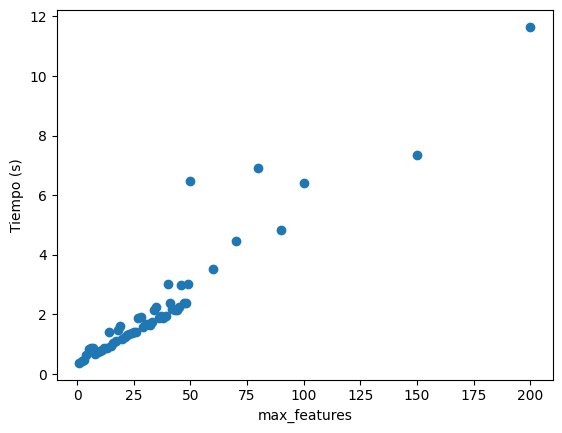

In [ ]:
plt.scatter(features, tiempos_y)
plt.xlabel("max_features")
plt.ylabel("Tiempo (s)")
plt.show()

A mayor número de `max_features`, mayor es el número de features tiene que fijarse el algoritmo para determinar cada nivel de los árboles por lo que tardará más tiempo en realizar este paso si el número de features a mirar es mayor.

REVISAR/ESCRIBIR MEJOR

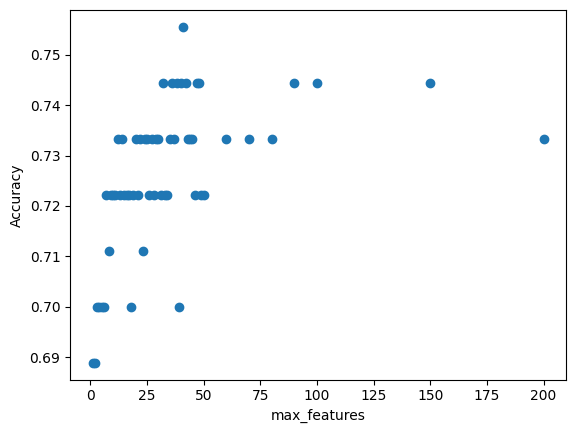

In [ ]:
plt.scatter(features, scores)
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print(f"El mejor accuracy parece ser para max_features={features[np.argmax(scores)]}.")

El mejor accuracy parece ser para max_features=41.


A pesar de eso, el accuracy no parece ser muy alto. Considerando además que tenemos 500 datos para aprender decisiones sobre 200 features, creemos necesario tener más datos.

In [ ]:
# quizas sea util al final

def youden(fpr, tpr, thresholds):
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

def validate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    for name, clf in classifiers.items():
        print('Validation for {0}'.format(name))
        pipeline_clf = make_pipeline(preprocessing.StandardScaler(), clf)
        pipeline_clf.fit(X_train, y_train)
        metrics.plot_roc_curve(pipeline_clf, X_test, y_test)
        churn_probas = pipeline_clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, churn_probas)
        youden_score = youden(fpr, tpr, thresholds)
        print('Youden spot ---> {0}'.format(youden_score))
        plt.show()